# Control probing for untrained model

The following notebook contains probing control tests performed for randomly initialized untrained model.

In [1]:
import math
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-untrained'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = {f'block_{i}': [] for i, _ in enumerate(model.transformer.h)}
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        for k in X.keys():
            X[k].append(activations[k][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = {k : torch.stack(X[k]) for k in X.keys()}
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X['block_0'].shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X['block_0'].shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [12]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [13]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [14]:
def train_probe(train_X, train_Y, val_X, val_Y, num_cls):
    results = {}
    for block in train_X.keys():
        print(block)

        probe = LinearBoardProbe(dim_x=train_X[block].shape[-1], dim_y=train_Y.shape[-1], num_cls=num_cls).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            probe.parameters(),
            lr=3e-4,
            weight_decay=1e-4
        )

        epochs = 1024
        batch_size = 1024

        train_loader = get_data_loader(train_X[block], train_Y, batch_size)
        val_loader = get_data_loader(val_X[block], val_Y, batch_size)

        for epoch in range(epochs):
            total_loss = 0
            for x, y in train_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                preds = probe(x)

                loss = criterion(
                    preds.view(-1, probe._num_cls),
                    y.view(-1)
                )

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            if epoch % 200 == 0:
                print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')
        results[block] = (probe, train_loader, val_loader)

    return results

Predict value of each cell

In [15]:
cell_probe_results = train_probe(train_X, train_Y_cell, val_X, val_Y_cell, num_cls=3)

block_0
Epoch   0: 1.0875
Epoch 200: 0.7276
Epoch 400: 0.7227
Epoch 600: 0.7224
Epoch 800: 0.7223
Epoch 1000: 0.7223
Epoch 1023: 0.7223
block_1
Epoch   0: 1.0808
Epoch 200: 0.6615
Epoch 400: 0.6549
Epoch 600: 0.6546
Epoch 800: 0.6546
Epoch 1000: 0.6546
Epoch 1023: 0.6546
block_2
Epoch   0: 1.0817
Epoch 200: 0.6291
Epoch 400: 0.6212
Epoch 600: 0.6209
Epoch 800: 0.6208
Epoch 1000: 0.6209
Epoch 1023: 0.6209
block_3
Epoch   0: 1.0746
Epoch 200: 0.6115
Epoch 400: 0.6033
Epoch 600: 0.6030
Epoch 800: 0.6030
Epoch 1000: 0.6030
Epoch 1023: 0.6030
block_4
Epoch   0: 1.0698
Epoch 200: 0.6016
Epoch 400: 0.5931
Epoch 600: 0.5928
Epoch 800: 0.5927
Epoch 1000: 0.5927
Epoch 1023: 0.5927
block_5
Epoch   0: 1.0674
Epoch 200: 0.5939
Epoch 400: 0.5847
Epoch 600: 0.5842
Epoch 800: 0.5843
Epoch 1000: 0.5842
Epoch 1023: 0.5841


Predict number of pieces in each column

In [16]:
col_probe_results = train_probe(train_X, train_Y_col, val_X, val_Y_col, num_cls=7)

block_0
Epoch   0: 1.9374
Epoch 200: 1.3202
Epoch 400: 1.2396
Epoch 600: 1.2232
Epoch 800: 1.2203
Epoch 1000: 1.2196
Epoch 1023: 1.2195
block_1
Epoch   0: 1.9347
Epoch 200: 1.2120
Epoch 400: 1.1141
Epoch 600: 1.0906
Epoch 800: 1.0854
Epoch 1000: 1.0842
Epoch 1023: 1.0841
block_2
Epoch   0: 1.9321
Epoch 200: 1.1592
Epoch 400: 1.0555
Epoch 600: 1.0278
Epoch 800: 1.0208
Epoch 1000: 1.0188
Epoch 1023: 1.0186
block_3
Epoch   0: 1.9288
Epoch 200: 1.1275
Epoch 400: 1.0222
Epoch 600: 0.9928
Epoch 800: 0.9848
Epoch 1000: 0.9823
Epoch 1023: 0.9821
block_4
Epoch   0: 1.9185
Epoch 200: 1.1094
Epoch 400: 1.0033
Epoch 600: 0.9724
Epoch 800: 0.9635
Epoch 1000: 0.9604
Epoch 1023: 0.9602
block_5
Epoch   0: 1.9311
Epoch 200: 1.0982
Epoch 400: 0.9897
Epoch 600: 0.9571
Epoch 800: 0.9469
Epoch 1000: 0.9433
Epoch 1023: 0.9429


Predict number of pieces in each row

In [17]:
row_probe_results = train_probe(train_X, train_Y_row, val_X, val_Y_row, num_cls=8)

block_0
Epoch   0: 2.0724
Epoch 200: 1.0770
Epoch 400: 1.0121
Epoch 600: 1.0031
Epoch 800: 1.0011
Epoch 1000: 1.0005
Epoch 1023: 1.0005
block_1
Epoch   0: 2.0550
Epoch 200: 1.0069
Epoch 400: 0.9521
Epoch 600: 0.9433
Epoch 800: 0.9412
Epoch 1000: 0.9405
Epoch 1023: 0.9404
block_2
Epoch   0: 2.0597
Epoch 200: 0.9733
Epoch 400: 0.9224
Epoch 600: 0.9130
Epoch 800: 0.9105
Epoch 1000: 0.9096
Epoch 1023: 0.9093
block_3
Epoch   0: 2.0396
Epoch 200: 0.9590
Epoch 400: 0.9102
Epoch 600: 0.9007
Epoch 800: 0.8978
Epoch 1000: 0.8966
Epoch 1023: 0.8965
block_4
Epoch   0: 2.0518
Epoch 200: 0.9515
Epoch 400: 0.9028
Epoch 600: 0.8927
Epoch 800: 0.8893
Epoch 1000: 0.8879
Epoch 1023: 0.8877
block_5
Epoch   0: 2.0453
Epoch 200: 0.9487
Epoch 400: 0.9001
Epoch 600: 0.8890
Epoch 800: 0.8853
Epoch 1000: 0.8834
Epoch 1023: 0.8834


### Test linear probes

In [18]:
def eval_probe_results(probe_results, dim):
    train_accuracies = {}
    val_accuracies = {}

    for block in probe_results.keys():
        probe, train_loader, val_loader = probe_results[block]

        def eval_loader(loader):
            correct = torch.zeros(dim, device=DEVICE)
            total = torch.zeros(dim, device=DEVICE)

            with torch.no_grad():
                for x, y in loader:
                    x = x.to(DEVICE)
                    y = y.to(DEVICE)

                    preds = probe(x)
                    pred_cls = preds.argmax(dim=-1)
                    matches = (pred_cls == y).float()

                    correct += matches.sum(dim=0)
                    total += torch.ones_like(matches).sum(dim=0)

            return correct / total

        train_accuracies[block] = eval_loader(train_loader)
        val_accuracies[block] = eval_loader(val_loader)

    return train_accuracies, val_accuracies

In [39]:
def plot_heatmaps(acc_dict, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False, max_cols=3):
    keys = sorted(acc_dict.keys())
    n = len(keys)

    # Grid layout
    cols = min(n, max_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(4 * cols, 4 * rows),
        squeeze=False
    )

    fig.suptitle(title, fontsize=16)

    for idx, key in enumerate(keys):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        board = acc_dict[key].view(h, w).cpu()
        im = ax.imshow(board, vmin=0.4, vmax=1)
        ax.set_title(key)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if disable_yticks:
            ax.set_yticks([])
        if disable_xticks:
            ax.set_xticks([])

        # Cell values
        for i in range(h):
            for j in range(w):
                val = board[i, j].item()
                ax.text(
                    j, i,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=9
                )

    # Remove empty subplots
    for i in range(n, rows * cols):
        fig.delaxes(axes[i // cols][i % cols])

    # Shared colorbar
    plt.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Accuracy")

    plt.show()

Per cell

In [40]:
train_acc_cell, val_acc_cell = eval_probe_results(cell_probe_results, dim=train_Y_cell.shape[-1])

In [41]:
train_acc_cell

{'block_0': tensor([0.7155, 0.7211, 0.7155, 0.6781, 0.7859, 0.8505, 0.8935, 0.6771, 0.6585,
         0.6323, 0.6180, 0.6947, 0.7839, 0.8512, 0.6554, 0.6544, 0.6259, 0.5977,
         0.6278, 0.6710, 0.7632, 0.6432, 0.6329, 0.6353, 0.5980, 0.6175, 0.6456,
         0.7254, 0.6215, 0.5987, 0.5911, 0.5439, 0.5865, 0.6062, 0.6803, 0.5846,
         0.5589, 0.5261, 0.5648, 0.5114, 0.5527, 0.5929], device='cuda:0'),
 'block_1': tensor([0.7522, 0.7552, 0.7475, 0.7096, 0.7928, 0.8505, 0.8954, 0.7230, 0.7199,
         0.7074, 0.6729, 0.7309, 0.7895, 0.8557, 0.7033, 0.6969, 0.6766, 0.6271,
         0.6909, 0.7121, 0.8031, 0.6727, 0.6581, 0.6593, 0.6240, 0.6587, 0.6957,
         0.7690, 0.6370, 0.6243, 0.6212, 0.5642, 0.6166, 0.6506, 0.7184, 0.5973,
         0.5863, 0.5884, 0.5713, 0.5585, 0.5846, 0.6189], device='cuda:0'),
 'block_2': tensor([0.7692, 0.7740, 0.7686, 0.7302, 0.8073, 0.8555, 0.9020, 0.7410, 0.7396,
         0.7217, 0.6867, 0.7529, 0.8066, 0.8703, 0.7150, 0.7115, 0.6879, 0.6387,
     

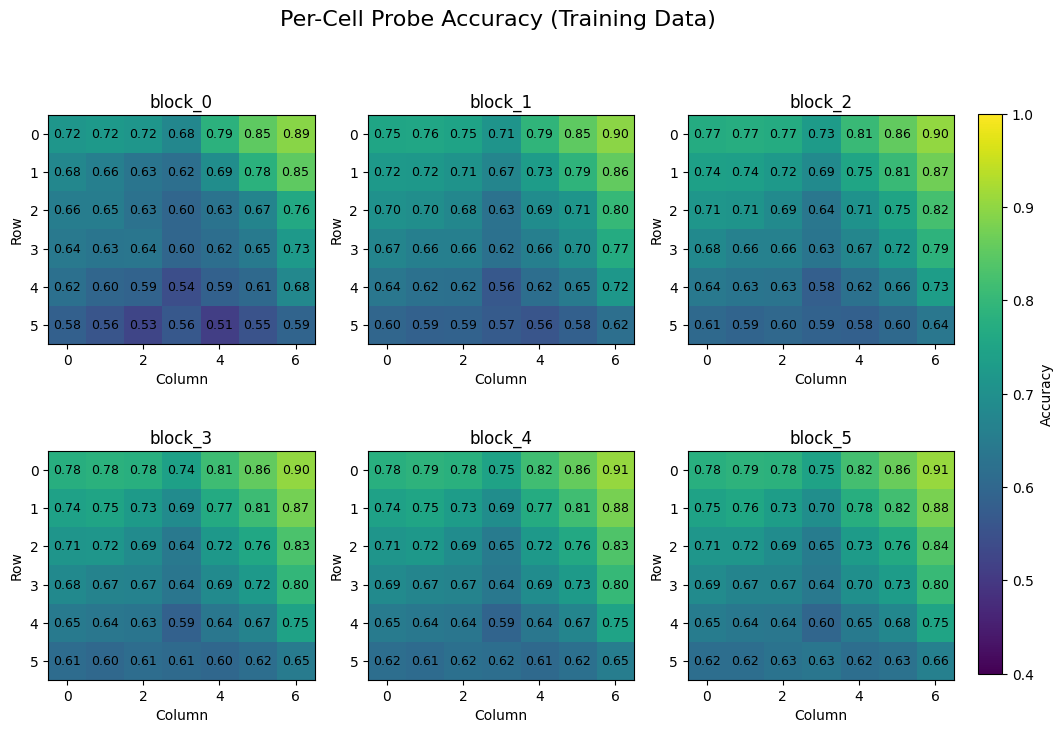

In [42]:
plot_heatmaps(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [43]:
val_acc_cell

{'block_0': tensor([0.7267, 0.7289, 0.7304, 0.6771, 0.7711, 0.8483, 0.8953, 0.6882, 0.6623,
         0.6432, 0.6068, 0.6850, 0.7764, 0.8589, 0.6496, 0.6549, 0.6089, 0.5930,
         0.6448, 0.6749, 0.7733, 0.6353, 0.6210, 0.6121, 0.5867, 0.6242, 0.6443,
         0.7320, 0.6290, 0.6020, 0.5899, 0.5470, 0.5809, 0.6126, 0.6702, 0.5677,
         0.5772, 0.5254, 0.5486, 0.4815, 0.5544, 0.5777], device='cuda:0'),
 'block_1': tensor([0.7627, 0.7579, 0.7590, 0.7093, 0.7775, 0.8483, 0.8959, 0.7225, 0.7236,
         0.7178, 0.6586, 0.7193, 0.7796, 0.8621, 0.6940, 0.6977, 0.6607, 0.6210,
         0.7045, 0.7215, 0.8129, 0.6649, 0.6490, 0.6485, 0.6073, 0.6570, 0.6882,
         0.7717, 0.6321, 0.6379, 0.6263, 0.5666, 0.6237, 0.6490, 0.7104, 0.5766,
         0.6057, 0.5766, 0.5618, 0.5391, 0.5877, 0.6004], device='cuda:0'),
 'block_2': tensor([0.7838, 0.7833, 0.7817, 0.7310, 0.7928, 0.8520, 0.8990, 0.7410, 0.7426,
         0.7310, 0.6749, 0.7405, 0.7992, 0.8758, 0.7067, 0.6998, 0.6697, 0.6321,
     

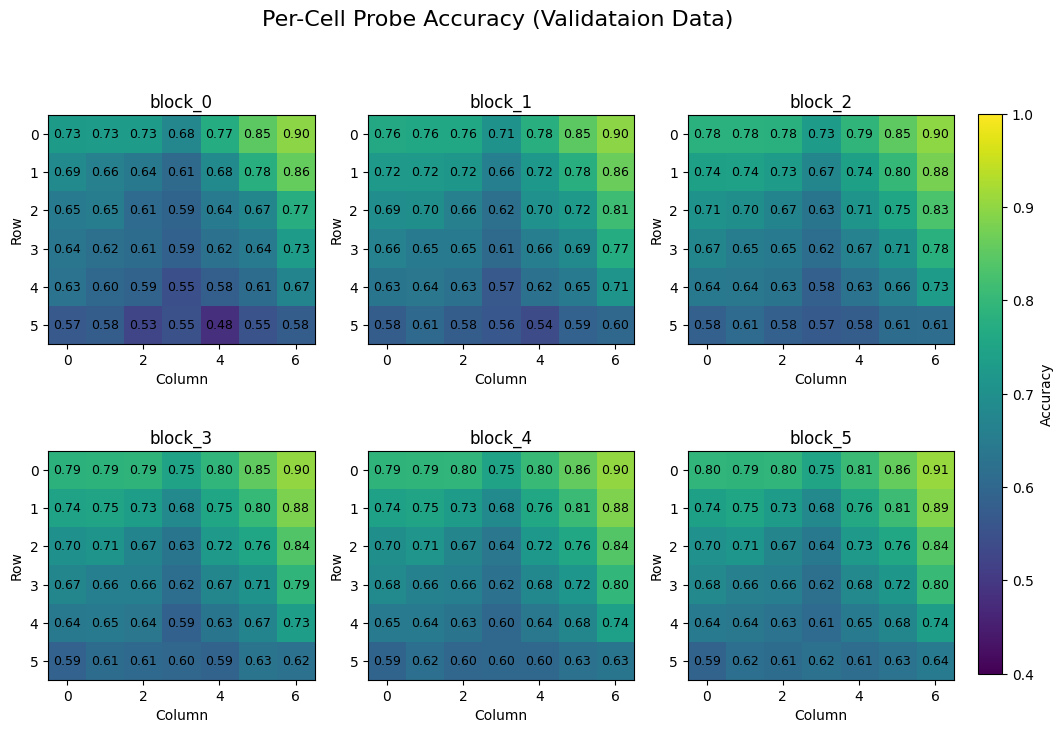

In [44]:
plot_heatmaps(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [45]:
train_acc_col, val_acc_col = eval_probe_results(col_probe_results, dim=train_Y_col.shape[-1])

In [46]:
train_acc_col

{'block_0': tensor([0.5468, 0.5591, 0.5518, 0.5525, 0.5439, 0.5270, 0.5253],
        device='cuda:0'),
 'block_1': tensor([0.6026, 0.6150, 0.6175, 0.5957, 0.5872, 0.5873, 0.5914],
        device='cuda:0'),
 'block_2': tensor([0.6394, 0.6428, 0.6392, 0.6192, 0.6054, 0.6089, 0.6305],
        device='cuda:0'),
 'block_3': tensor([0.6501, 0.6562, 0.6547, 0.6334, 0.6229, 0.6187, 0.6541],
        device='cuda:0'),
 'block_4': tensor([0.6584, 0.6657, 0.6646, 0.6463, 0.6310, 0.6264, 0.6690],
        device='cuda:0'),
 'block_5': tensor([0.6649, 0.6739, 0.6719, 0.6551, 0.6389, 0.6301, 0.6739],
        device='cuda:0')}

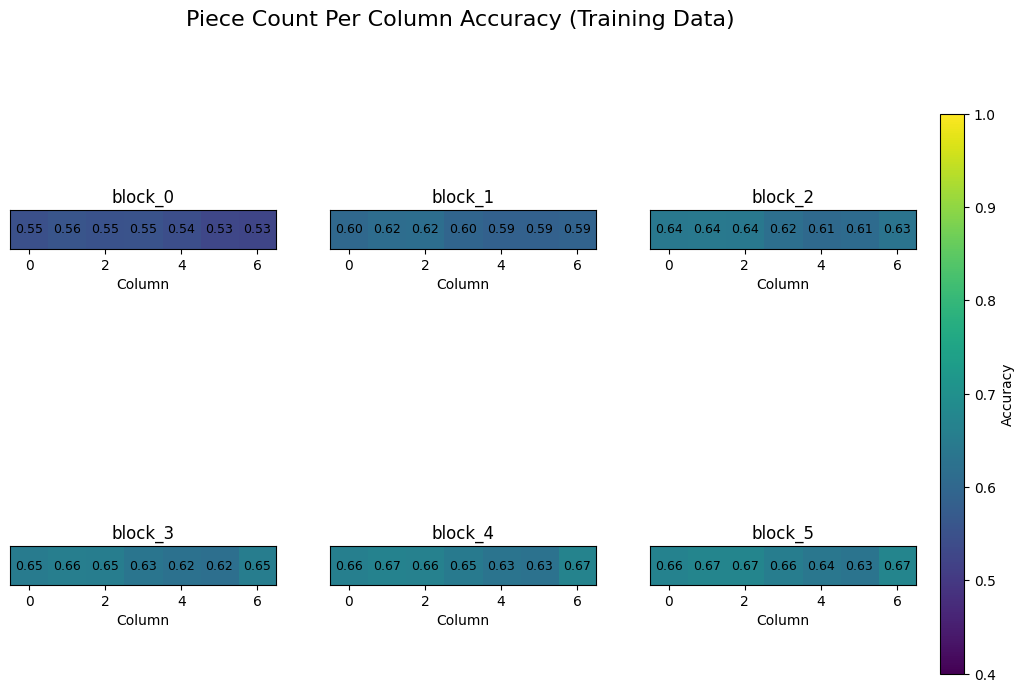

In [47]:
plot_heatmaps(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [48]:
val_acc_col

{'block_0': tensor([0.5581, 0.5449, 0.5544, 0.5460, 0.5655, 0.5259, 0.5238],
        device='cuda:0'),
 'block_1': tensor([0.6078, 0.5951, 0.6147, 0.5946, 0.6041, 0.5830, 0.5766],
        device='cuda:0'),
 'block_2': tensor([0.6395, 0.6136, 0.6364, 0.6168, 0.6205, 0.5999, 0.6163],
        device='cuda:0'),
 'block_3': tensor([0.6475, 0.6253, 0.6517, 0.6316, 0.6358, 0.6163, 0.6358],
        device='cuda:0'),
 'block_4': tensor([0.6570, 0.6332, 0.6586, 0.6459, 0.6459, 0.6184, 0.6543],
        device='cuda:0'),
 'block_5': tensor([0.6591, 0.6422, 0.6601, 0.6522, 0.6527, 0.6284, 0.6538],
        device='cuda:0')}

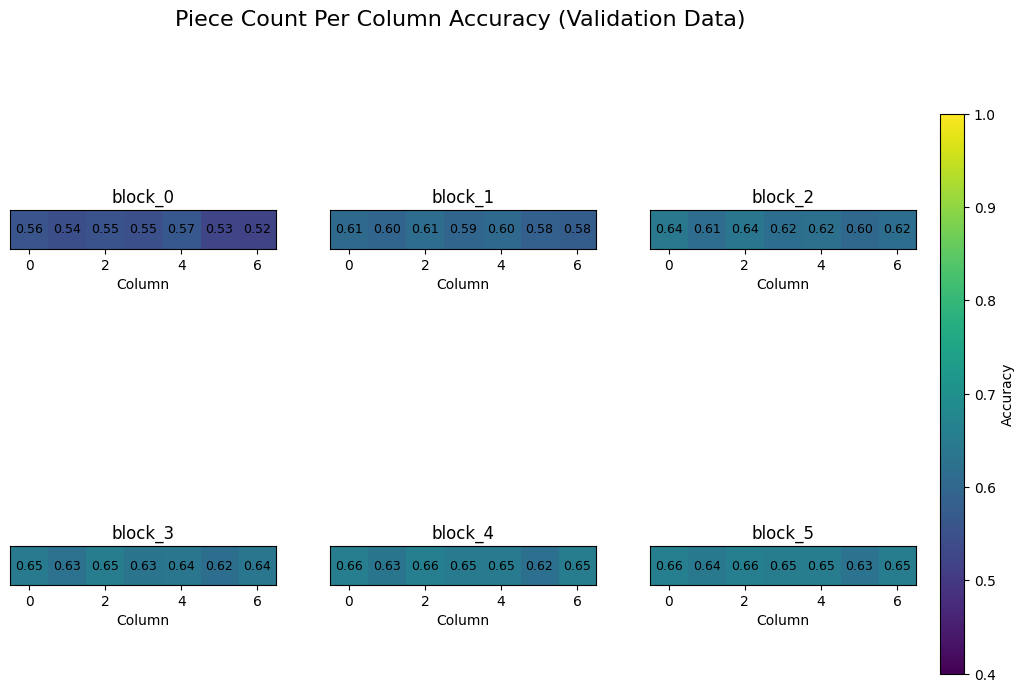

In [49]:
plot_heatmaps(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [50]:
train_acc_row, val_acc_row = eval_probe_results(row_probe_results, dim=train_Y_row.shape[-1])

In [51]:
train_acc_row

{'block_0': tensor([0.6394, 0.5903, 0.6087, 0.6192, 0.5908, 0.6016], device='cuda:0'),
 'block_1': tensor([0.6522, 0.6039, 0.6186, 0.6280, 0.6021, 0.6083], device='cuda:0'),
 'block_2': tensor([0.6574, 0.6128, 0.6294, 0.6283, 0.6067, 0.6102], device='cuda:0'),
 'block_3': tensor([0.6601, 0.6134, 0.6356, 0.6336, 0.6074, 0.6140], device='cuda:0'),
 'block_4': tensor([0.6629, 0.6173, 0.6358, 0.6329, 0.6099, 0.6147], device='cuda:0'),
 'block_5': tensor([0.6628, 0.6199, 0.6363, 0.6359, 0.6105, 0.6148], device='cuda:0')}

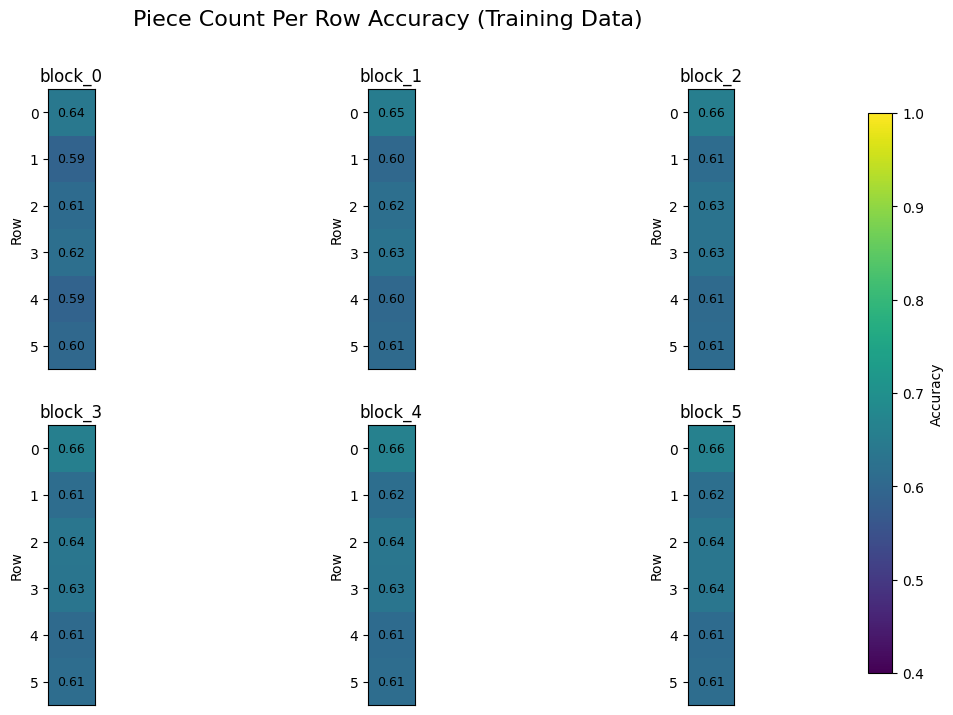

In [52]:
plot_heatmaps(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [53]:
val_acc_row

{'block_0': tensor([0.6591, 0.6041, 0.6131, 0.6342, 0.5957, 0.5936], device='cuda:0'),
 'block_1': tensor([0.6654, 0.6195, 0.6279, 0.6395, 0.6004, 0.6062], device='cuda:0'),
 'block_2': tensor([0.6681, 0.6152, 0.6432, 0.6390, 0.5941, 0.6084], device='cuda:0'),
 'block_3': tensor([0.6686, 0.6205, 0.6406, 0.6364, 0.5962, 0.6084], device='cuda:0'),
 'block_4': tensor([0.6697, 0.6179, 0.6459, 0.6406, 0.5978, 0.6131], device='cuda:0'),
 'block_5': tensor([0.6670, 0.6210, 0.6464, 0.6406, 0.6041, 0.6121], device='cuda:0')}

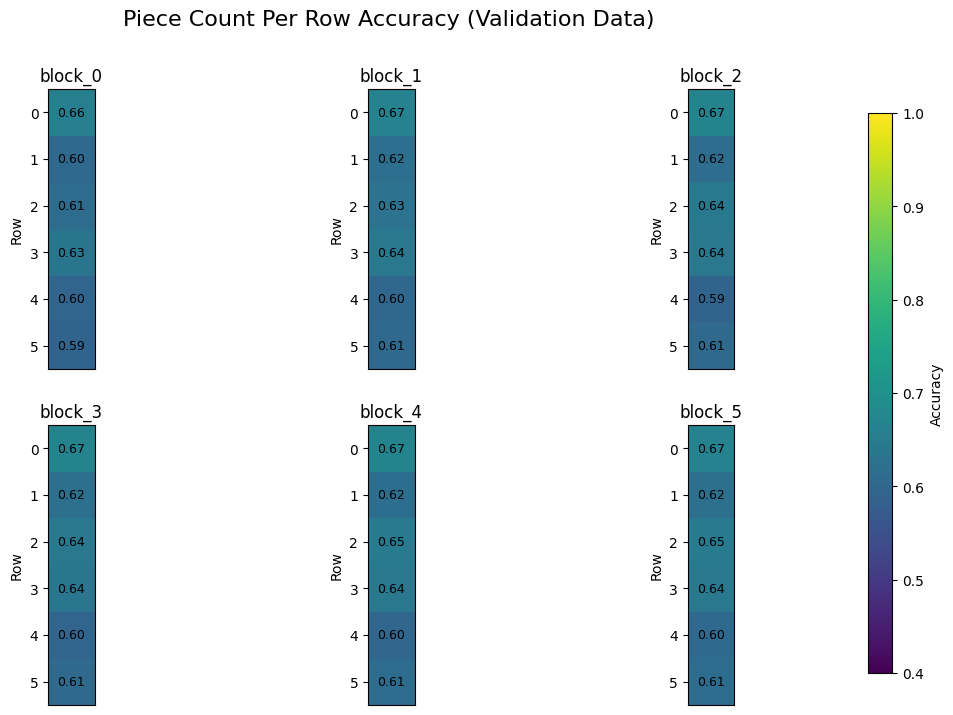

In [54]:
plot_heatmaps(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)